In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
import pandas as pd
import os
import holidays

def preprocess_data(df):
    # Convert the 'TIME' column to datetime
    df['TIME'] = pd.to_datetime(df['TIME'])

    # Split the 'TIME' column into separate columns
    df = split_time_column(df)

    # Add weekday columns
    df = add_weekday_columns(df)

    # Add holiday column
    df = add_holiday_column(df)

    # Add season column
    df = add_season_column(df)

    # Add part of day column
    df = add_part_of_day_column(df)

    return df

def split_time_column(df):
    df['YEAR'] = df['TIME'].dt.year
    df['MONTH'] = df['TIME'].dt.month
    df['DAY'] = df['TIME'].dt.day
    df['HOUR'] = df['TIME'].dt.hour
    df['MINUTE'] = df['TIME'].dt.minute
    return df

def add_weekday_columns(df):
    df['DAY_OF_WEEK'] = df['TIME'].dt.dayofweek
    df['IsWeekend'] = df['DAY_OF_WEEK'].apply(lambda x: 0 if x < 5 else 1)
    return df

def add_holiday_column(df):
    ie_holidays = holidays.Ireland()
    df['IS_HOLIDAY'] = df['TIME'].apply(lambda x: x in ie_holidays)
    return df

def get_season(month):
    if 3 <= month <= 5:
        return 1  # Spring
    elif 6 <= month <= 8:
        return 2  # Summer
    elif 9 <= month <= 11:
        return 3  # Autumn
    else:
        return 0  # Winter

def add_season_column(df):
    df['SEASON'] = df['MONTH'].apply(get_season)
    return df

def get_part_of_day(hour):
    if 6 <= hour <= 11:
        return 0  # Morning
    elif 12 <= hour <= 17:
        return 1  # Afternoon
    elif 18 <= hour <= 23:
        return 2  # Evening
    else:
        return 3  # Night

def add_part_of_day_column(df):
    df['PART_OF_DAY'] = df['HOUR'].apply(get_part_of_day)
    return df

# Specify the directory containing the data files
data_directory = 'bike dataset for model/'

# Initialize empty datasets
full_datasets = []  # Use a list to store multiple datasets
specific_dataset = pd.DataFrame()

# Iterate through files in the directory
for filename in os.listdir(data_directory):
    if filename.startswith('cleaned_concatenated_data_without_duplicates'):
        # Load the data
        file_path = os.path.join(data_directory, filename)
        
        # Read the file in smaller chunks
        chunksize = 10**5  # Adjust chunk size as needed
        chunks = pd.read_csv(file_path, chunksize=chunksize)
        
        # Process each chunk and append it to the list
        for chunk in chunks:
            # Preprocess the chunk
            processed_chunk = preprocess_data(chunk)
            
            # Check if the filename contains '2023-12'
            if '2023-12' in filename:
                # Append data to specific dataset
                specific_dataset = pd.concat([specific_dataset, processed_chunk], ignore_index=True)
            else:
                # Append data to the list of full datasets
                full_datasets.append(processed_chunk)

# Combine all full datasets into a single DataFrame
full_dataset = pd.concat(full_datasets, ignore_index=True)

In [ ]:
# Find the date corresponding to 12 months ago from the current date
twelve_months_ago = pd.Timestamp.now() - pd.DateOffset(months=12)

# Filter the dataset to keep only the rows where the "TIME" is within the last 12 months
full_dataset = full_dataset[full_dataset['TIME'] >= twelve_months_ago]

In [ ]:
# # Preprocess the datasets
processed_full_dataset = preprocess_data(full_dataset)
#processed_specific_dataset = preprocess_data(specific_dataset)

# # Display or further process the datasets as needed
print("Processed Full Dataset:")
print(processed_full_dataset.head())


In [ ]:
# Assuming processed_specific_dataset is initialized as an empty DataFrame
processed_specific_dataset = pd.DataFrame()

# Specify the date range for the 12th month
start_date_12th_month = '2023-12-01'
end_date_12th_month = '2023-12-31'

# Filter data to exclude the 12th month
filtered_out_data = processed_full_dataset[((processed_full_dataset['TIME'] >= start_date_12th_month) & (processed_full_dataset['TIME'] <= end_date_12th_month))]
full_dataset_filtered = processed_full_dataset[~((processed_full_dataset['TIME'] >= start_date_12th_month) & (processed_full_dataset['TIME'] <= end_date_12th_month))]

# Store removed data in processed_specific_dataset
processed_specific_dataset = pd.concat([processed_specific_dataset, filtered_out_data], ignore_index=True)

# Display or further process the updated datasets
print("Full Dataset (Excluding 12th Month):")
print(full_dataset_filtered.count())

print("Specific Dataset (12th Month Data Only):")
print(processed_specific_dataset.count())

In [ ]:
#data pre processing 
data = full_dataset_filtered
data.count()

In [ ]:
#specific_dataset['TIME'] = pd.to_datetime(specific_dataset['TIME'])
validation=processed_specific_dataset
validation

In [ ]:

#data['TIME'] = pd.to_datetime(data['TIME'])

# Sort the data by 'STATION ID' and 'TIME'
data = data.sort_values(by=['STATION ID', 'TIME'])

# Calculate the difference in 'AVAILABLE_BIKES' compared to the previous row for each station
data['previous_available_bikes'] = data.groupby('STATION ID')['AVAILABLE_BIKES'].shift(1)
data['bike_difference'] = data['AVAILABLE_BIKES'] - data['previous_available_bikes']

# Calculate bike usage for each row
data['bike_usage'] = data['bike_difference'] / data['BIKE_STANDS']

# Create a new column for time intervals (every 59 minutes)
data['time_interval'] = data['TIME'].dt.floor('15T')  # '59T' represents 59 minutes

# Group by date and time intervals, then calculate the mean bike usage for each interval per station
usage_per_interval = data.groupby(['TIME', 'time_interval', 'STATION ID', 'NAME', 'BIKE_STANDS', 'AVAILABLE_BIKE_STANDS', 'AVAILABLE_BIKES', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'IsWeekend', 'IS_HOLIDAY', 'SEASON', 'PART_OF_DAY'])['bike_usage'].mean().reset_index()

# Print the result
usage_per_interval


In [ ]:


# Assuming 'usage_per_interval_validation' is your DataFrame

# Calculate the trend based on the 'bike_usage' column
usage_per_interval['trend_interval'] = (usage_per_interval['bike_usage'] >= 0).astype(int)

# Print the updated DataFrame
print(usage_per_interval)


In [ ]:
# Assuming validation is your DataFrame for data_after_2023-12-29
validation['TIME'] = pd.to_datetime(validation['TIME'])

# Sort the data by 'STATION ID' and 'TIME'
validation = validation.sort_values(by=['STATION ID', 'TIME'])

# Calculate the difference in 'AVAILABLE_BIKES' compared to the previous row for each station
validation['previous_available_bikes'] = validation.groupby('STATION ID')['AVAILABLE_BIKES'].shift(1)
validation['bike_difference'] = validation['AVAILABLE_BIKES'] - validation['previous_available_bikes']

# Calculate bike usage for each row
validation['bike_usage'] = validation['bike_difference'] / validation['BIKE_STANDS']

# Create a new column for time intervals (every 59 minutes)
validation['time_interval'] = validation['TIME'].dt.floor('15T')  # '59T' represents 59 minutes

# Group by date and time intervals, then calculate the mean bike usage for each interval per station
usage_per_interval_validation = validation.groupby(['TIME', 'time_interval', 'STATION ID', 'NAME', 'BIKE_STANDS', 'AVAILABLE_BIKE_STANDS', 'AVAILABLE_BIKES', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'IsWeekend', 'IS_HOLIDAY', 'SEASON', 'PART_OF_DAY'])['bike_usage'].mean().reset_index()

# Print the result
usage_per_interval_validation


In [ ]:
# Assuming 'usage_per_interval_validation' is your DataFrame

# Calculate the trend based on the 'bike_usage' column
usage_per_interval_validation['trend_interval'] = (usage_per_interval_validation['bike_usage'] >= 0).astype(int)

# Print the updated DataFrame
print(usage_per_interval_validation)


In [ ]:
import pandas as pd

# Assuming usage_per_interval_validation contains the validation dataset

# Convert the timestamp to datetime format
timestamp = pd.to_datetime('2023-12-01 00:00:03')

# Extract data for the specified timestamp
data_at_timestamp = usage_per_interval_validation[usage_per_interval_validation['TIME'] == timestamp]




In [ ]:

filtered_usage = usage_per_interval[pd.notna(usage_per_interval['bike_usage'])]



In [ ]:
columns_to_drop = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'NAME', 'AVAILABLE_BIKE_STANDS']
filtered_usage = filtered_usage.drop(columns=columns_to_drop)


In [ ]:


station_datasets = {}

# Iterate through unique station IDs
for station_id in filtered_usage['STATION ID'].unique():
    # Filter data for the current station ID
    station_data = filtered_usage[filtered_usage['STATION ID'] == station_id].copy()
    station_datasets[station_id] = station_data





In [ ]:
station_datasets.get(507)

In [ ]:
import pickle
def train_prophet_model(station_data):
    # Rename columns to match Prophet's requirements
    station_data.rename(columns={'TIME': 'ds', 'AVAILABLE_BIKES': 'y'}, inplace=True)
    
    # Train Prophet model
    model = Prophet(daily_seasonality=False, yearly_seasonality=False)
    model.add_seasonality(name='custom_daily', period=24, fourier_order=9)
    model.add_seasonality(name='custom_weekly', period=24*7, fourier_order=9)


        # 2. Add Additional Regressors
    model.add_regressor('temperature')
    model.add_regressor('precipitation')
    model.add_regressor('trend_interval')

        # 3. Experiment with Changepoint Prior
    model = Prophet(changepoint_prior_scale=0.01)

    # Fit the model
    model.fit(station_data)
    
    return model

# Train and save Prophet models for each station
prophet_models = {}

for station_id, data in station_datasets.items():
    print(station_id)
    prophet_models[station_id] = train_prophet_model(data)


for station_id, model in prophet_models.items():
    with open(f"prophet_model_station_{station_id}.pkl", "wb") as f:
        pickle.dump(model, f)

In [ ]:
prediction_timestamp = pd.to_datetime("2023-12-27 00:30:00")

# Convert the 'TIME' column in usage_per_interval_validation to datetime if needed
usage_per_interval_validation['TIME'] = pd.to_datetime(usage_per_interval_validation['TIME'])

# Filter usage_per_interval_validation for the specific timestamp
filtered_usage_validation = usage_per_interval_validation[usage_per_interval_validation['TIME'] == pd.to_datetime("2023-12-27 00:30:02")]
filtered_usage_validation

In [ ]:
import pickle
import pandas as pd
import numpy as np

# Load the saved Prophet models
prophet_models = {}
for station_id in station_datasets.keys():
    with open(f"prophet_model_station_{station_id}.pkl", "rb") as f:
        prophet_models[station_id] = pickle.load(f)

# Define the timestamp for prediction
prediction_timestamp = pd.to_datetime("2023-12-27 00:30:02")

# Filter usage_per_interval_validation for the specific timestamp
filtered_usage_validation = usage_per_interval_validation[usage_per_interval_validation['TIME'] == prediction_timestamp]

# Initialize a DataFrame to store the predictions
predictions_df = pd.DataFrame(columns=['STATION ID', 'predicted_available_bikes'])

# Make predictions for each station
for station_id, model in prophet_models.items():
    # Prepare the data for prediction
    future = pd.DataFrame({'ds': [prediction_timestamp]})
    
    # Make prediction
    forecast = model.predict(future)
    predicted_available_bikes = forecast['yhat'].values[0]
    
    # Store the prediction in the DataFrame
    predictions_df = predictions_df.append({'STATION ID': station_id, 'predicted_available_bikes': predicted_available_bikes}, ignore_index=True)




In [21]:
import pandas as pd

# Load the dataset
data = pd.read_csv("cleaned_concatenated_data_without_duplicates.csv")

# Keep the important columns
important_columns = ['STATION ID','TIME', 'BIKE_STANDS','AVAILABLE_BIKES']

# Drop irrelevant columns
data = data[important_columns]

# Convert the 'TIME' column to datetime format
data['TIME'] = pd.to_datetime(data['TIME'])

# Extract additional features from the 'TIME' column
data['hour'] = data['TIME'].dt.hour
data['day_of_week'] = data['TIME'].dt.dayofweek
data['month'] = data['TIME'].dt.month

# Display the preprocessed dataset
print(data.head())


   STATION ID                TIME  BIKE_STANDS  AVAILABLE_BIKES  hour  \
0           2 2021-10-01 00:00:03           20               13     0   
1           3 2021-10-01 00:00:03           20               19     0   
2           4 2021-10-01 00:00:03           20                9     0   
3           5 2021-10-01 00:00:03           40               40     0   
4           6 2021-10-01 00:00:03           20               16     0   

   day_of_week  month  
0            4     10  
1            4     10  
2            4     10  
3            4     10  
4            4     10  


In [22]:
end_date = data['TIME'].max()
start_date = end_date - pd.DateOffset(years=0, months=5)
filtered_data = data[data['TIME'] >= start_date]


Correlation Matrix:
                   STATION ID          TIME   BIKE_STANDS  AVAILABLE_BIKES  \
STATION ID       1.000000e+00  5.125410e-15  5.555460e-01         0.058116   
TIME             5.125410e-15  1.000000e+00  8.181430e-14        -0.001414   
BIKE_STANDS      5.555460e-01  8.181430e-14  1.000000e+00         0.200736   
AVAILABLE_BIKES  5.811574e-02 -1.414459e-03  2.007364e-01         1.000000   
hour             6.897267e-17  4.970143e-03  4.256289e-16        -0.015006   
day_of_week      8.687573e-17 -1.710579e-02 -1.624447e-15         0.010750   
month            6.663214e-15  9.804067e-01  7.964128e-14        -0.001378   

                         hour   day_of_week         month  
STATION ID       6.897267e-17  8.687573e-17  6.663214e-15  
TIME             4.970143e-03 -1.710579e-02  9.804067e-01  
BIKE_STANDS      4.256289e-16 -1.624447e-15  7.964128e-14  
AVAILABLE_BIKES -1.500634e-02  1.074988e-02 -1.378052e-03  
hour             1.000000e+00 -2.176133e-04 -1.425383e

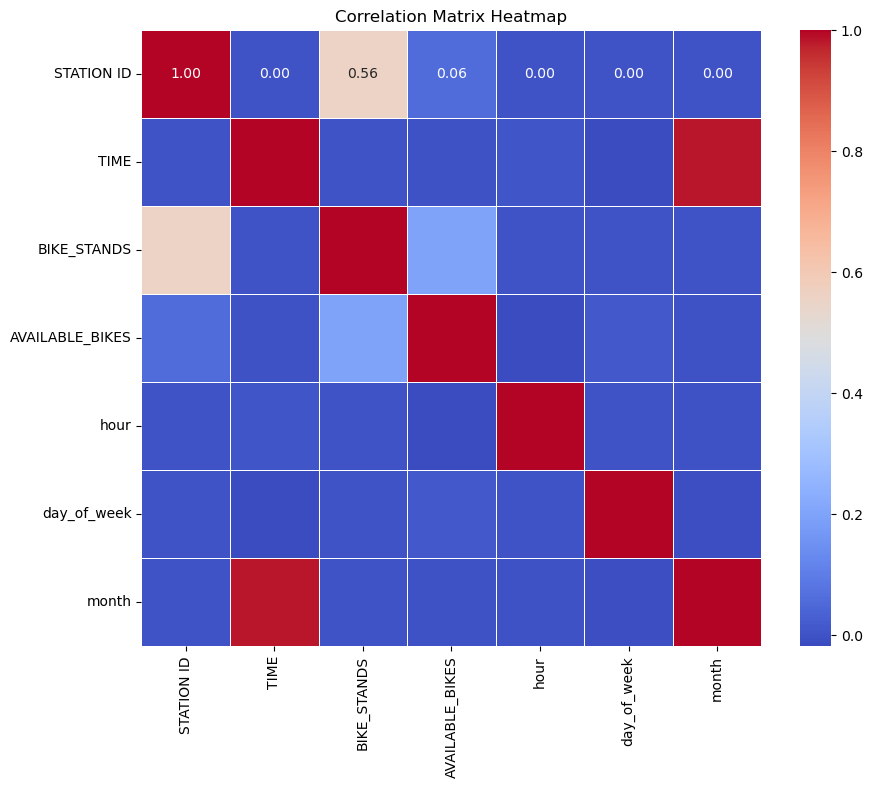

In [23]:
correlation_matrix = filtered_data.corr()

# Display correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Plot correlation matrix as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()